In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mne
BATCH_SIZE = 32

In [ ]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (22, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(16*17, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)
        
        x = x.view(-1, 16*17)
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

class ShallowConvNet(nn.Module):
    def __init__(self):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (22, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        # self.SquareLayer = square_layer()
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        # self.LogLayer = Log_layer()
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*74, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*74)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

class SCCNet(nn.Module):
    def __init__(self):
        super(SCCNet, self).__init__()
        # bs, 1, channel, sample
        self.conv1 = nn.Conv2d(1, 22, (22, 1))
        self.Bn1 = nn.BatchNorm2d(22)
        # bs, 22, 1, sample
        self.conv2 = nn.Conv2d(22, 20, (1, 12), padding=(0, 6))
        self.Bn2   = nn.BatchNorm2d(20)
        # self.SquareLayer = square_layer()
        self.Drop1 = nn.Dropout(0.5)
        self.AvgPool1 = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.classifier = nn.Linear(840, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.Bn1(x)
        x = self.conv2(x)
        x = self.Bn2(x)
        x = x ** 2
        x = self.Drop1(x)
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = x.view(-1, 840)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [ ]:
from torchsummary import summary
model = SCCNet().to('cuda')
print(model)

SCCNet(
  (conv1): Conv2d(1, 22, kernel_size=(22, 1), stride=(1, 1))
  (Bn1): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(22, 20, kernel_size=(1, 12), stride=(1, 1), padding=(0, 6))
  (Bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Drop1): Dropout(p=0.5, inplace=False)
  (AvgPool1): AvgPool2d(kernel_size=(1, 62), stride=(1, 12), padding=0)
  (classifier): Linear(in_features=840, out_features=4, bias=True)
)


In [ ]:
# Dataloader
# 依據不同的scheme組成dataset
def choose_scheme(path, scheme):
  filedir = os.listdir(path)
  x_train, x_test, y_train, y_test = [], [], [], []
  x_fine_tune, y_fine_tune = [], []
  # 將第一個subject 1固定作為testing subject
  subject_t = "BCIC_S01_T.mat"
  subject_e = "BCIC_S01_E.mat"
  x_train = torch.Tensor(io.loadmat(os.path.join(path, subject_t))['x_train']).unsqueeze(1)
  y_train = torch.Tensor(io.loadmat(os.path.join(path, subject_t))['y_train']).view(-1).long()
  x_test = torch.Tensor(io.loadmat(os.path.join(path, subject_e))['x_test']).unsqueeze(1)
  y_test = torch.Tensor(io.loadmat(os.path.join(path, subject_e))['y_test']).view(-1).long()
  len_x = x_train.size()[0]

  # 依序將其他subject的data讀入
  for filename in filedir:
    #print(filename)
    if filename in {subject_t, subject_e}:
      continue
    elif filename.endswith('E.mat'):
      x = torch.Tensor(io.loadmat(os.path.join(path, filename))['x_test']).unsqueeze(1)
      y = torch.Tensor(io.loadmat(os.path.join(path, filename))['y_test']).view(-1).long()
      x_train = torch.cat([x_train, x])
      y_train = torch.cat([y_train, y])
    elif filename.endswith('T.mat'):
      x = torch.Tensor(io.loadmat(os.path.join(path, filename))['x_train']).unsqueeze(1)
      y = torch.Tensor(io.loadmat(os.path.join(path, filename))['y_train']).view(-1).long()
      x_train = torch.cat([x_train, x])
      y_train = torch.cat([y_train, y])

  # choose real training and testing data based on scheme
  if scheme == 'individual': # indiviual will access only training session from subject1
    return [x_train[:len_x], y_train[:len_x], x_test, y_test]
  elif scheme == 'dependent': # dependent scheme collect all data except for the testing sessions from sub1
    return [x_train, y_train, x_test, y_test]
  elif scheme == 'independent': # independent scheme collect all data except for testing and training session from sub1
    return [x_train[len_x:], y_train[len_x:], x_test, y_test]
  elif scheme == 'fine-tune': # the data used on fine tune is the same as individual scheme
    return [x_train[:len_x], y_train[:len_x], x_test, y_test]
  else:
    raise ValueError('unexpected scheme, enter other scheme again')
  
def get_dataloader(data_path, scheme):
  data = []
  data = choose_scheme(data_path, scheme)

  x_train, y_train, x_test, y_test = data

  print("x_train shape: ", x_train.size())
  print("y_train shape: ", y_train.size())
  print("x_test shape: ", x_test.size())
  print("y_test shape: ", y_test.size())

  # 存成tensordataset
  train_dataset = TensorDataset(x_train, y_train)
  test_dataset = TensorDataset(x_test, y_test)
  # 包成dataloader
  train_dl = DataLoader(
      dataset = train_dataset,
      batch_size = BATCH_SIZE,
      shuffle = True,
      num_workers = 0   
  )
  test_dl = DataLoader(
      dataset = test_dataset,
      batch_size = len(test_dataset),
      shuffle = False,
      num_workers = 0   
  )
  return [train_dl, test_dl]

In [ ]:
def train_model(model, train_dl, test_dl, device, config):
  # set the optimizer and corresponding loss function
  optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr=config['lr'])
  criterion = nn.CrossEntropyLoss()
  #lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
  record = {
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': []
      }
  
  max_acc = 0
  print('\n training start')
  # start training process
  for epoch in range(config['epoch']):
    model.train()
    train_loss = 0
    train_acc = 0
    for x_train, y_train in train_dl:
      x_train, y_train = x_train.to(device), y_train.to(device)
      optimizer.zero_grad()
      out = model(x_train) # model prediction
      loss = criterion(out, y_train) # calculate loss
      pred = torch.argmax(out, axis = 1) # max out the prediction
      train_loss += loss.detach().cpu().item()
      train_acc += (pred==y_train).sum().item() # count the corrected classified casese

      loss.backward() # derive backpropagation
      optimizer.step() # update model
    
    # save the model which produce maximum validation accuracy
    val_acc = val_model(model, test_dl, device)
    if(val_acc>max_acc):
      max_acc = val_acc
      torch.save(model.state_dict(), f"{config['save_path']+config['model']}_{config['scheme']}_{config['lr']}_{BATCH_SIZE}")

    record['train_loss'].append(train_loss/len(train_dl))
    record['train_acc'].append(train_acc/len(train_dl.dataset))
    record['val_acc'].append(val_acc)
      
    #lr_scheduler.step()
    if (epoch+1)%10 == 0:
      print(f'epoch: {epoch+1}, training acc: {train_acc/len(train_dl.dataset)} val_acc: {val_acc}')
  
  return record

def val_model(model, test_dl, device):
  model.eval()
  # print('test start')
  acc = 0
  with torch.no_grad():
    for x_test, y_test in test_dl:
      x_test, y_test = x_test.to(device), y_test.to(device)
      pred = model(x_test)
      pred = torch.argmax(pred, axis = 1)
      acc += (pred==y_test).sum().item()
  acc /= len(test_dl.dataset)
 
  return acc

def test_model(model, test_dl, device):
  model.eval()
  # print('test start')
  acc = 0
  output = []
  with torch.no_grad():
    for x_test, y_test in test_dl:
      x_test, y_test = x_test.to(device), y_test.to(device)
      pred = model(x_test)
      pred = torch.argmax(pred, axis = 1)
      output.append(pred)
      acc += (pred==y_test).sum().item()
  acc /= len(test_dl.dataset)
  print(f"testing accuracy: {acc*100}%")
 
  return output

In [ ]:
def main():
  device = get_device()
  set_seed(33)
  file_dir = '/content/gdrive/Shareddrives/BCI/BCI_data'
  scheme = 'independent' # individual, dependent, independent, fine-tune
  dl = get_dataloader(file_dir, scheme)

  if scheme == 'fine-tune':
    tune_dl, test_dl = dl  
    config = {
        'epoch': 300,
        'optimizer': 'Adam',
        'lr': 0.001,
        'model': 'EEGNet',
        'scheme': scheme,
        'save_path': '/content/gdrive/Shareddrives/BCI/model/'
    }
    # os.makedirs('/content/gdrive/MyDrive/model', exist_ok=True)
    model = EEGNet().to(device)
    model.load_state_dict(torch.load('/content/gdrive/Shareddrives/BCI/model/SCCNet_independent_0.001_128')) # 要改load model的檔名
    #for name, param in model.named_parameters():
    #  if name != 'classifier.weight' and name != 'classifier.bias':
    #    param.requires_grad = False
    loss_record = train_model(model, tune_dl, test_dl, device, config)
  else:
    train_dl, test_dl = dl
    model = EEGNet().to(device)
    config = {
        'epoch': 500,
        'optimizer': 'Adam',
        'lr': 0.0001,
        'scheme': scheme,
        'model': 'EEGNet',
        'save_path': '/content/gdrive/Shareddrives/BCI/model/'
    }
    # os.makedirs('/content/gdrive/MyDrive/model', exist_ok=True)
    loss_record = train_model(model, train_dl, test_dl, device, config)

  # plot confusion matrix
  model = EEGNet().to(device)
  model.load_state_dict(torch.load(f"{config['save_path']+config['model']}_{config['scheme']}_{config['lr']}_{BATCH_SIZE}")) # 要改load model的檔名
  plot_confusion_matrix(model, test_dl, device)
  
def plot_confusion_matrix(model, test_dl, device):
  pred = test_model(model, test_dl, device)
  _, y_test = next(iter(test_dl))
  cm = confusion_matrix(y_test, pred[0].cpu(), normalize = 'pred')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.plot()

x_train shape:  torch.Size([4608, 1, 22, 562])
y_train shape:  torch.Size([4608])
x_test shape:  torch.Size([288, 1, 22, 562])
y_test shape:  torch.Size([288])

 training start
epoch: 10, training acc: 0.2955729166666667 val_acc: 0.5104166666666666
epoch: 20, training acc: 0.3487413194444444 val_acc: 0.5833333333333334
epoch: 30, training acc: 0.3884548611111111 val_acc: 0.5659722222222222
epoch: 40, training acc: 0.4142795138888889 val_acc: 0.5763888888888888
epoch: 50, training acc: 0.4162326388888889 val_acc: 0.6180555555555556
epoch: 60, training acc: 0.4216579861111111 val_acc: 0.6076388888888888
epoch: 70, training acc: 0.4377170138888889 val_acc: 0.625
epoch: 80, training acc: 0.4578993055555556 val_acc: 0.625
epoch: 90, training acc: 0.4494357638888889 val_acc: 0.6319444444444444
epoch: 100, training acc: 0.45703125 val_acc: 0.6284722222222222
epoch: 110, training acc: 0.4730902777777778 val_acc: 0.6423611111111112
epoch: 120, training acc: 0.4800347222222222 val_acc: 0.6423611

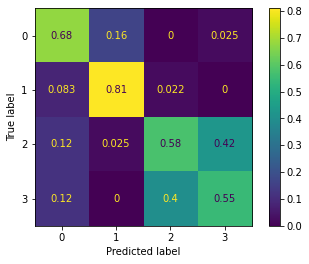

In [ ]:
if __name__ == "__main__":
  main()

In [ ]:
#plot topographic map of the spatial kernel by using mne
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
n_channels = len(biosemi_montage.ch_names)
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=250.,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data = rng.normal(size=(n_channels, 1)) * 1e-6
fake_evoked = mne.EvokedArray(data, fake_info)
fake_evoked.set_montage(biosemi_montage)

# the channels use in this dataset
chs = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']

montage_head = fake_evoked.get_montage()
ch_pos = montage_head.get_positions()['ch_pos']
pos = np.stack([ch_pos[ch] for ch in chs])

In [ ]:
model = SCCNet()
model.load_state_dict(torch.load('/content/gdrive/Shareddrives/BCI/model/SCCNet_independent_0.001_128'))
print(model)

# obtain the kernel weight of spatial filter and map to each channel
kernels = model.conv1.weight
fig = plt.figure(figsize=(15,10))
for i in range(22):
  w = kernels[i].detach().numpy()
  w = np.reshape(w, -1)

  plt.subplot(5, 5, i+1)
  plt.title('Kernel %d'%(i+1))
  mne.viz.plot_topomap(w, pos[:, :2], show = False)